<a href="https://colab.research.google.com/github/jasreman8/LLMs-for-Classification-and-Text-Generation/blob/main/Iterative_LLM_Summarization_%2B_Evaluation_(BERTScore%2C_LLM_Judge).ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Learning Objectives

- Implement an iterative workflow that uses LLMs for summarization tasks.
- Use BERTScore and LLM-as-a-Judge to evaluate summarization outputs.

# Setup

In [1]:
!pip install -q openai==1.66.3 \
                datasets==3.3.2 \
                evaluate==0.4.3 \
                bert-score==0.3.13

In [2]:
import json
import pandas as pd

from openai import OpenAI
from datasets import load_dataset
from google.colab import userdata
from evaluate import load
from tqdm import tqdm

In [3]:
openai_api_key = userdata.get('my_api_key')

client = OpenAI(
    api_key=openai_api_key,
)

model_name = 'gpt-4o-mini'

# Text - Text Generation Tasks

## Overview

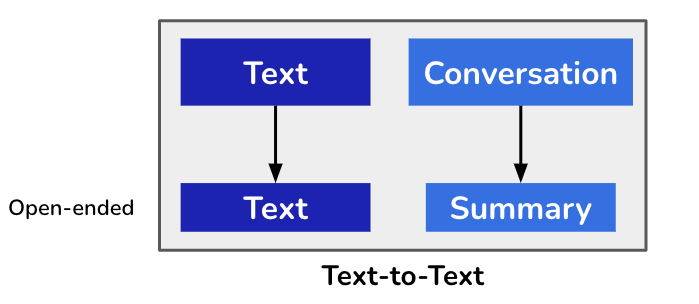

Text-to-Text generation problems are another class of important problems that LLMs solve effectively. In this notebook, we present an approach to design and evaluate prompts for text-to-text tasks using summarization as an example. The approach followed in this notebook can be extended to any other text-to-text task as well.

We begin by presenting a workflow for prompt design and evaluation for text generation tasks.

## Workflow

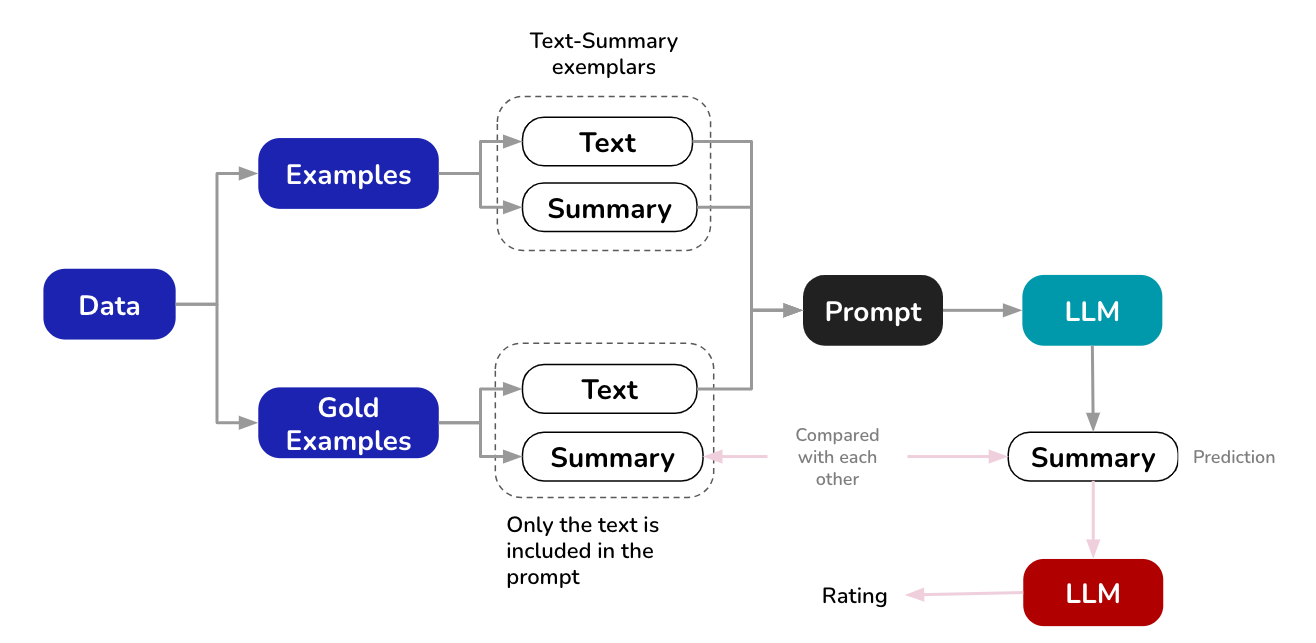

As indicated in the above figure, the data used to achieve text generation tasks comprises examples and gold examples. Examples are input-output exemplars included in the prompt to prime it for expected output generation. Gold examples are inputs for which we have ground truth available and predictions from the LLM for the inputs is compared with the ground truths. We choose the best *prompt* as the one that scores high on predefined metrics on the set of gold examples. Unlike classification though, here we have to contend with subjective output. This complicates the evaluation process (including the difficulty in collecting human generated baselines), and it is common to use LLMs to evaluate the quality of outputs (referred to as LLM-as-a-judge).

## Evaluation

Given the subjective nature of text generation, there are two ways in which generation tasks could be evaluated.

- When human annotations are available, evaluation is done using BERTScore. BERTScore is an automatic evaluation metric for text generation tasks that leverages the pre-trained contextual embeddings from BERT to compute the semantic similarity between the generated text (candidate) and the reference text, rather than relying on exact token matches.

- When human annotations are not available, we use another LLM to rate the performance of the LLM used in the generation task (see figure below for an example in case of summarization). This method of using LLMs to evaluate LLMs is usualy referred to as LLM-as-a-judge. When LLMs are used to evaluate output, the system message should clearly define the rubrics used for evaluation and the key aspects of the output that should be evaluated. The advantage of using LLMs as judges is that we do not need human baselines (that are costly to collect), while writing down the rubrics for assessment is usually an easier task.

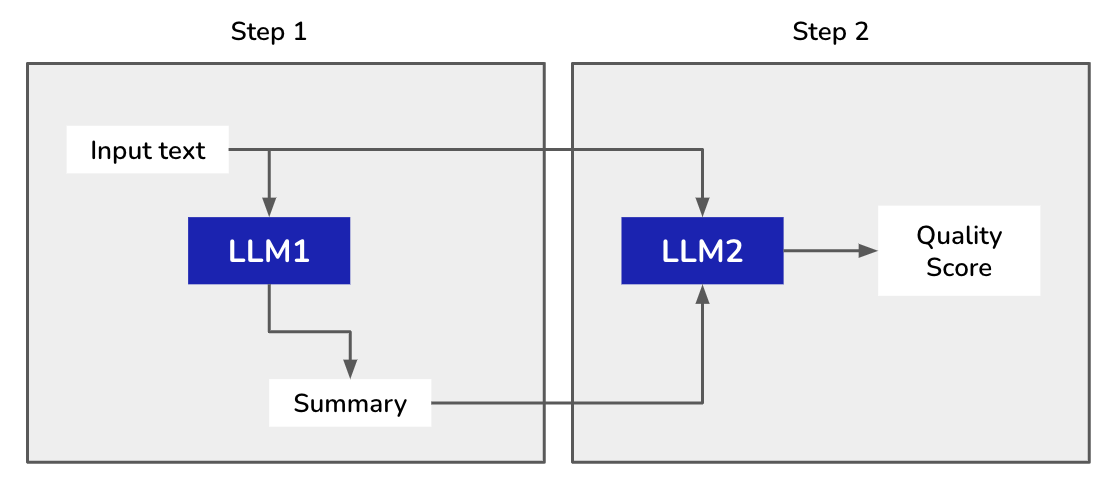

Let us now implement this workflow for diaogue summarization on a sample of conversations.

# Summarization

## Business Use Case

Summarizing customer interactions with sales employees or interactions between employees can be a source of valuable information. Customer interactions can point towards pain points or positives about a product. Summarizing meetings and deriving action points from meetings improves organizational efficiency. There are several other situations where text generation is of value for the enterprise (se elist below).


1. *Customer Support Automation:*
   - *Input:* Customer inquiries or complaints in text form.
   - *Output:* Automated responses or suggested solutions generated in response to customer queries.

2. *Email Autoresponders:*
   - *Input:* Incoming emails.
   - *Output:* Automatic email responses generated based on predefined rules or machine learning algorithms.

3. *Content Generation:*
   - *Input:* Prompts or specifications for content creation.
   - *Output:* Generated articles, stories, or creative pieces in response to the input.

4. *Code Generation:*
    - *Input:* Descriptions or requirements for a program.
    - *Output:* Automatically generated code based on the input specifications.

5. *Automated Report Generation:*
    - *Input:* Data sets or parameters.
    - *Output:* Automatically generated reports or summaries describing the data.

6. *Social Media Posting:*
    - *Input:* Drafts or prompts for social media posts.
    - *Output:* Published social media content.

## Prompt Design

We will design and evaluate two few-shot prompts for summarization. We first assemble a set of examples (input-output exemplars) as a part of the few-shot prompt. Then we create the prompt in the Anyscale API format.

To evaluate the performance of the *prompt* we will use a set of *gold examples*, that is, a set of examples that is not presented to the model as a part of the prompt.  

**Examples and Gold Examples**

In [4]:
dataset = load_dataset("pgurazada1/dialogsum")

/usr/local/lib/python3.12/dist-packages/huggingface_hub/utils/_auth.py:94: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


**Assembling the prompt**

Let us now assemble 4 examples from this dataset of 32 dialogue examples. We also collect the 32 gold examples.

In [5]:
dialogue_summary_examples_df = dataset['examples'].to_pandas()
dialogue_summary_gold_examples_df = dataset['gold_examples'].to_pandas()
dialogue_summary_examples_df.shape, dialogue_summary_gold_examples_df.shape

((32, 2), (32, 2))

In [6]:
examples_df = dialogue_summary_examples_df.sample(4, random_state=42)
examples_df

,dialogue,summary
29,#Person1#: Are you free on the thirteenth in t...,#Person1# and #Person2# are arranging for thei...
15,"#Person1#: Excuse me mam, can you tell me how ...",#Person1# asks #Person2# how to get to Son Col...
24,#Person1#: I'll show you around and explain th...,#Person1# shows #Person2# around and explains ...
17,"#Person1#: Would you like something to drink, ...",#Person1# prepares coffee for #Person1#'s moth...


We need to iterate over the rows of the examples DataFrame to append these examples as `user` and `assistant` messages to the few-shot prompt. We achieve this using the `iterrows` method.

In [7]:
for index, row in examples_df.iterrows():
    print('Example Dialogue:')
    print(row.iloc[0])
    print('Example Summary:')
    print(row.iloc[1])
    break

Example Dialogue:
#Person1#: Are you free on the thirteenth in the afternoon?
#Person2#: No I'm afraid not. I'm meeting Ruth then. How about the fourteenth in the morning?
#Person1#: I'm sorry. I'm attending a meeting at the Hilton then.
#Person2#: What about the next day?
#Person1#: No. I'm busy then too. I'm meeting Dorothy Heath at North Bridge Road. Are you free on Thursday afternoon?
#Person2#: Yes, I think I am. Let's meet for lunch at mouth restaurant.
#Person1#: Good idea! Is two o'clock okay?
#Person2#: That's fine. See you there!
Example Summary:
#Person1# and #Person2# are arranging for their next meeting. They decide to meet on Thursday afternoon.


*First prompt variant*

In [8]:
system_message_v1 = """
Summarize the dialogue mentioned in the user input. Be specific and concise in your summary.
"""

In [9]:
few_shot_prompt_v1 = [{'role': 'developer', 'content': system_message_v1}]

We need to iterate over the rows of the examples DataFrame to append these examples as `user` and `assistant` messages to the few-shot prompt. We achieve this using the `iterrows` method.

In [10]:
for index, row in examples_df.iterrows():
    user_input_example = row.iloc[0]
    assistant_output_example = row.iloc[1]

    few_shot_prompt_v1.append(
        {
            'role': 'user',
            'content': user_input_example
        }
    )

    few_shot_prompt_v1.append(
        {
            'role': 'assistant',
            'content': assistant_output_example
        }
    )

In [11]:
few_shot_prompt_v1

[{'role': 'developer',
  'content': '\nSummarize the dialogue mentioned in the user input. Be specific and concise in your summary.\n'},
 {'role': 'user',
  'content': "#Person1#: Are you free on the thirteenth in the afternoon?\n#Person2#: No I'm afraid not. I'm meeting Ruth then. How about the fourteenth in the morning?\n#Person1#: I'm sorry. I'm attending a meeting at the Hilton then.\n#Person2#: What about the next day?\n#Person1#: No. I'm busy then too. I'm meeting Dorothy Heath at North Bridge Road. Are you free on Thursday afternoon?\n#Person2#: Yes, I think I am. Let's meet for lunch at mouth restaurant.\n#Person1#: Good idea! Is two o'clock okay?\n#Person2#: That's fine. See you there!"},
 {'role': 'assistant',
  'content': '#Person1# and #Person2# are arranging for their next meeting. They decide to meet on Thursday afternoon.'},
 {'role': 'user',
  'content': "#Person1#: Excuse me mam, can you tell me how to get to Son College? I'm walking.\n#Person2#: Well, I think the simp

**Evaluation**

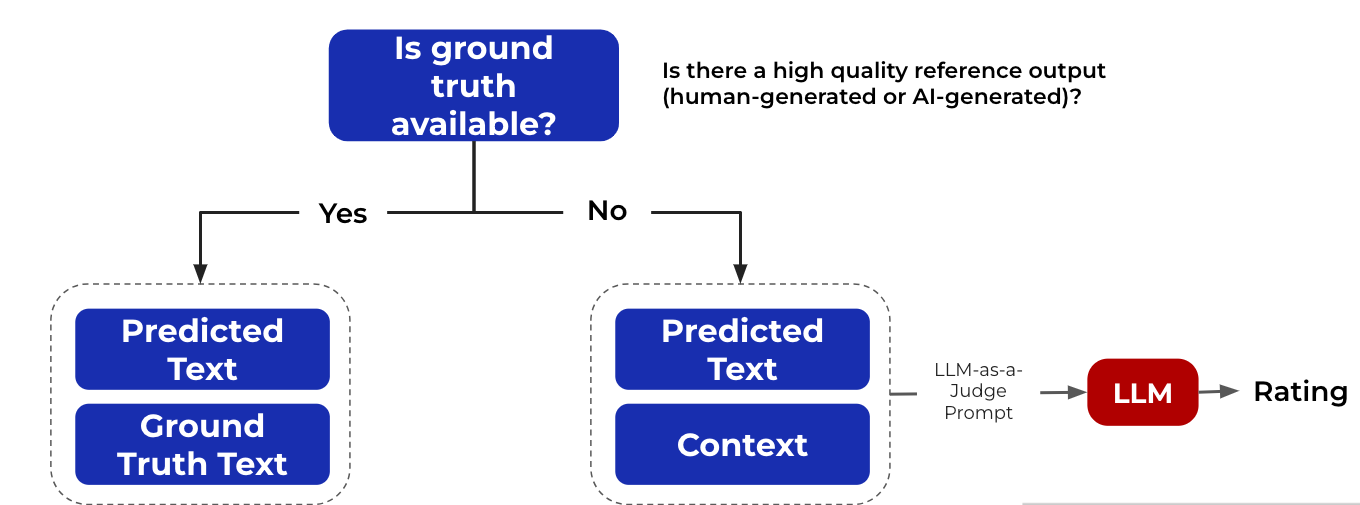

Since this is abstractive summarization and we have the ground truth available, we will use BERTScore to compare the predictions with ground truths.

In [12]:
def predict(gold_examples_df, prompt):
    """Generates predictions for a set of gold examples using an LLM.

    This function iterates through a DataFrame of gold examples,
    formats each example as a prompt for an LLM, and generates a prediction.
    It also stores the ground truth summaries for evaluation.

    Args:
        gold_examples_df (pd.DataFrame): A DataFrame containing gold examples
            with dialogues and summaries.
            The first column should contain the dialogue,
            and the second column should contain the summary.
        prompt (list): A list of dictionaries containing the prompt for the LLM in the Azure Open AI API format.

    Returns:
        tuple: A tuple containing two lists:
            - predictions (list): A list of predicted summaries.
            - ground_truths (list): A list of ground truth summaries.

    Raises:
        Exception: If an error occurs during prediction, it logs the error and continues.
    """
    predictions, ground_truths = [], []  # Initialize empty lists to store predictions and ground truths

    # Iterate through the gold examples DataFrame using tqdm for progress bar
    for index, row in tqdm(gold_examples_df.iterrows()):
        gold_dialogue = row.iloc[0]  # Get the gold dialogue from the first column
        gold_summary = row.iloc[1]  # Get the gold summary from the second column

        # Format the dialogue as a user input for the LLM
        user_input = [{'role':'user', 'content': gold_dialogue}]
        try:
            # Generate a prediction using the LLM
            response = client.chat.completions.create(
                model=model_name,
                messages=prompt + user_input
                )

            predictions.append(response.choices[0].message.content)  # Store the prediction
            ground_truths.append(gold_summary)  # Store the ground truth
        except Exception as e:
            print(e)  # Log error and continue
            continue

    # Return the predictions and ground truths
    return predictions, ground_truths

In [13]:
predictions, ground_truths = predict(dialogue_summary_gold_examples_df, few_shot_prompt_v1)

32it [00:48,  1.53s/it]


In [14]:
bertscore = load("bertscore")

In [15]:
results = bertscore.compute(
    predictions=predictions,
    references=ground_truths,
    lang="en"
)

Some weights of RobertaModel were not initialized from the model checkpoint at roberta-large and are newly initialized: ['pooler.dense.bias', 'pooler.dense.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


In [16]:
sum(results['f1'])/len(results['f1'])

0.8962055929005146

The above score indicates that the summarization was of very high quality. Let us now try a different few-shot system message (keeping the examples the same) and see if we can improve this result.

*Second prompt variant*

In [17]:
system_message_v2 = """
You are an AI assistant tasked to summarize dialogues mentioned in the user input.
Summarize these conversations by extracting key points, main topics and critical details while omitting repetitive or irrelevant information.

Use the following guidelines for your summary:
1. Be concise. Use short and clear sentences without unnecessary elaboration.
2. Capture the essense of the conversation, including its primary topics, decisions and actions.
3. Avoid adding interpretations or opinions.
4. Ensure the summary flows logically, even when brief.
5. Retain essential names, dates, or actions that are crucial for understanding the conversations context.
6. For long or complex conversations, prioritize summarizing in chronological or thematic order.

Your output should be a concise paragraph of 4 or fewer sentences (less than 50 words).
"""

In [18]:
few_shot_prompt_v2 = [{'role':'developer', 'content': system_message_v2}]

In [19]:
for index, row in examples_df.iterrows():
    user_input_example = row.iloc[0]
    assistant_output_example = row.iloc[1]

    few_shot_prompt_v2.append(
        {
            'role': 'user',
            'content': user_input_example
        }
    )

    few_shot_prompt_v2.append(
        {
            'role': 'assistant',
            'content': assistant_output_example
        }
    )

In [20]:
few_shot_prompt_v2

[{'role': 'developer',
  'content': '\nYou are an AI assistant tasked to summarize dialogues mentioned in the user input.\nSummarize these conversations by extracting key points, main topics and critical details while omitting repetitive or irrelevant information.\n\nUse the following guidelines for your summary:\n1. Be concise. Use short and clear sentences without unnecessary elaboration.\n2. Capture the essense of the conversation, including its primary topics, decisions and actions.\n3. Avoid adding interpretations or opinions.\n4. Ensure the summary flows logically, even when brief.\n5. Retain essential names, dates, or actions that are crucial for understanding the conversations context.\n6. For long or complex conversations, prioritize summarizing in chronological or thematic order.\n\nYour output should be a concise paragraph of 4 or fewer sentences (less than 50 words).\n'},
 {'role': 'user',
  'content': "#Person1#: Are you free on the thirteenth in the afternoon?\n#Person2#:

**Evaluation**

In [21]:
predictions, ground_truths = predict(dialogue_summary_gold_examples_df, few_shot_prompt_v2)

32it [00:42,  1.34s/it]


In [22]:
results = bertscore.compute(
    predictions=predictions,
    references=ground_truths,
    lang="en"
)

In [23]:
sum(results['f1'])/len(results['f1'])

0.8997633885592222

There is a slight improvement with this prompt. We can use this as our final prompt on summarizing new dialogues.



In [24]:
final_system_message =  """
You are an AI assistant tasked to summarize dialogues mentioned in the user input.
Summarize these conversations by extracting key points, main topics and critical details while omitting repetitive or irrelevant information.

Use the following guidelines for your summary:
1. Be concise. Use short and clear sentences without unnecessary elaboration.
2. Capture the essense of the conversation, including its primary topics, decisions and actions.
3. Avoid adding interpretations or opinions.
4. Ensure the summary flows logically, even when brief.
5. Retain essential names, dates, or actions that are crucial for understanding the conversations context.
6. For long or complex conversations, prioritize summarizing in chronological or thematic order.

Your output should be a concise paragraph of 4 or fewer sentences (less than 50 words).
"""

In [25]:
new_dialogue = """
#Person1#: Are you available on the 20th in the morning?
#Person2#: Sorry, no. I have a dentist appointment then. How about the 21st in the afternoon?
#Person1#: Unfortunately, I’m tied up with a presentation at the office that day.
#Person2#: How about the 22nd?
#Person1#: I can’t do that either. I have a lunch meeting with Mr. Tan at Marina Bay Sands. Could we meet on Friday morning instead?
#Person2#: Friday morning works for me. Shall we meet at The Coffee House?
#Person1#: That’s a great idea! How about 10:30?
#Person2#: Perfect. See you there!
"""

In [26]:
final_prompt = [{'role': 'developer', 'content': final_system_message}]
user_input = [{'role': 'user', 'content': new_dialogue}]

response = client.chat.completions.create(
    model=model_name,
    messages=final_prompt + user_input
)

print(response.choices[0].message.content)

Person1 and Person2 discussed scheduling a meeting. Person1 is unavailable on the 20th, 21st, and 22nd due to a dentist appointment, office presentation, and a lunch meeting, respectively. They agreed to meet on Friday morning at The Coffee House at 10:30.


**(Alternative Method) LLM-as-a-judge**

As an alternative method to evaluate the quality of the output, let us use the LLM-as-a-Judge template with faithfulness being the metric.

In [27]:
rater_model = 'gpt-4o-mini'

In [28]:
rater_system_message = """
You are tasked with rating AI-generated summaries of dialogues based on the given metric.
You will be presented a dialogue and an AI generated summary of the dialogue as the input.
In the input, the dialogue will begin with ###Dialogue while the AI generated summary will begin with ###Summary.

Evaluation criteria:
The task is to judge the extent to which the metric is followed by the summary.
1 - The metric is not followed at all
2 - The metric is followed only to a limited extent
3 - The metric is followed to a good extent
4 - The metric is followed mostly
5 - The metric is followed completely

Metric:
Faithfulness: Factual accuracy and verifiability of the information presented in the summary.
Every piece of information mentioned in the summary should be directly verifiable, supported, or reasonably inferred from the source.
Summaries should be penalized if they contain any information that cannot be traced back to the dialogue or if they overgeneralize information.

Instructions:
1. First write down the steps that are needed to evaluate the summary as per the metric.
2. Give a step-by-step explanation if the summary adheres to the metric considering the dialogues as the input.
3. Next, evaluate the extent to which the metric is followed.
4. Use the previous information to rate the summary using the evaluaton criteria and assign a score.
5. Document your step-by-step evaluation before presenting the final output in the following JSON format:
```json
{
    "score": <score>
}
```
"""

In [29]:
rater_user_message_template = """
###Dialogue
{dialogue}

###Summary
{summary}
"""

In [30]:
ratings = []

In [31]:
for gold_dialogue, prediction in tqdm(zip(dialogue_summary_gold_examples_df.dialogue, predictions)):

    rater_prompt = [
        {
            'role': 'developer',
            'content': rater_system_message
        },
        {
            'role': 'user',
            'content': rater_user_message_template.format(
                dialogue=gold_dialogue,
                summary=prediction
            )
        }
    ]

    response = client.chat.completions.create(
        model=rater_model,
        messages=rater_prompt
    )

    ratings.append(response.choices[0].message.content)

32it [03:40,  6.89s/it]


Let us inspect a rating and formulate a mechanism to extract the scores out that we can then average.

In [32]:
print(ratings[0])

To evaluate the summary, we will follow these steps:

1. **Identify Key Details from the Dialogue**: Extract the main points and details from the dialogue that are essential to the conversation.
2. **Compare Summary with Dialogue**: Check if the summary includes all the important details from the dialogue and if the information is accurate.
3. **Assess Factual Accuracy**: Ensure that every piece of information in the summary can be traced back to the dialogue without introducing inaccuracies or overgeneralizations.
4. **Evaluate Completeness**: Determine if the summary presents a complete picture of the dialogue without leaving out significant information.
5. **Rate According to the Metric**: Use the scoring system based on how well the summary adheres to the metric of faithfulness.

Now, let's analyze the summary based on the dialogue provided:

### Step-by-step Evaluation:
1. **Key Details from the Dialogue**: 
   - Person2 initially has no dinner plans and suggests frozen pizza.
   

Since the score is a JSON nested between ``\`json and ```, we can find the indexes of these and slice the output to extract the score like so (note that the JSON format that we specified might not be followed by the LLM in all cases):

In [33]:
scores = []

# Iterate through the 32 ratings
for i in range(32):
    try:
        # Find the start and end indices of the JSON string within the rating
        start_index = ratings[i].find('```json') # Find the start index of the JSON string
        end_index = ratings[i].rfind('```')  # Find the end index of the JSON string
        # Extract and parse the JSON string
        result = json.loads(ratings[i][start_index+7:end_index].strip())  # Extract the JSON string and parse it using json.loads()
        # Append the score from the parsed JSON to the list of scores
        scores.append(result['score'])  # Append the score to the list
    except Exception as e:
        # Print the rating if there is an error parsing the JSON
        print(ratings[i])  # Print the rating if an error occurs

In [34]:
sum(scores)/len(scores)

4.84375

This high rating indicates high adherence to the metric.